In [40]:
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet, stopwords
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import squarify
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_size(SIZE = 20):
    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)
    

# 1. Text Classification

In [3]:
data = pd.read_csv("data/socialmedia_relevant_cols.csv", encoding='ISO-8859-1', usecols=[0,2])
data.columns=['text', 'class_label']
data.head()

,text,class_label
0,Just happened a terrible car crash,1
1,Our Deeds are the Reason of this #earthquake M...,1
2,"Heard about #earthquake is different cities, s...",1
3,"there is a forest fire at spot pond, geese are...",1
4,Forest fire near La Ronge Sask. Canada,1


Since our purpose is doing text classification, it's clear that we have to use a dataset labelled.

In [4]:
data.describe()

,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


As you can see, we have in 10876 docs in our dataset.

## 1.1 Data Wrangling

#### Is this dataset a balanced designe ?

In [5]:
data.groupby('class_label').count()

,text
class_label,
0,6187
1,4673
2,16


* First, 0 means `not a disaster doc`, 1 means `disaster doc` and 2 means `not sure`.
* Secondly, the dataset is clearly not balanced. It means that (normally) we have to do something (matching) to re design our dataset such that it will be balanced. Why ? ....

I decided to remove all text labelled `2`

In [6]:
data = data[data['class_label'] < 2]

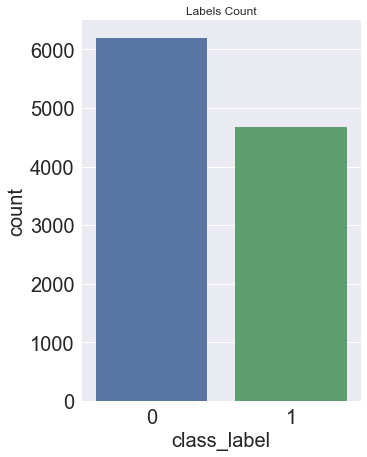

In [7]:
set_size()
plt.subplots(figsize=(5,7))
sns.set(style="darkgrid")
sns.countplot(x=data['class_label'],order=data['class_label'].value_counts().index)
plt.title('Labels Count')
plt.show()

#### Processing text

* This step is the most important and most difficult when we dealing with text. 
* It decides how well your performance is and takes most of time while dealing with text.
* 

In [8]:
"""
   First, depend on the dataset and on the purpose, we decide what to exclude.
   Need to see some samples in the dataset and try to detect some special things to be removed
   For instant, we remove urls, hashtag, @, numbers, punctuations 
"""

urls_re = r'http\S+' #urls
ht_re = r'#\S+'      #hashtags
at_re = r'@\S+'      #@
nb_re = " \d+"       #numbers

punctuations = ["/","(",")","\\","|", ":",",",";",".","?", "!", "[", "]", "{","}"]

def standardize_text(df, text_field):
    new_text = []
    for text in df[text_field]:
        
        text = text.replace("\\n"," ").replace("\n", " ").replace("-"," ").replace("_"," ").replace('amp'," ").replace('co', " ")
        
        for x in punctuations:
            text = text.replace(x , " ")
            
        text = re.sub(urls_re , " ", text)
        text = re.sub(ht_re   , " ", text)
        text = re.sub(at_re   , " ", text)
        text = re.sub(nb_re   , " ", text)
        
        text = text.replace("http"," ")
        
        new_text.append(text.lower())
    
    df['standardized_' + text_field] = new_text
    return df

data = standardize_text(data, "text")
data.head()

,text,class_label,standardized_text
0,Just happened a terrible car crash,1,just happened a terrible car crash
1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this may allah f...
2,"Heard about #earthquake is different cities, s...",1,heard about is different cities stay safe e...
3,"there is a forest fire at spot pond, geese are...",1,there is a forest fire at spot pond geese are...
4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada


In [9]:
def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [10]:
"""
    Secondly, we need to choose `indexing terms` for our TFIDF matrix. Step by step:
        - Tokenization: splitting the text into words (actually a NLP issue, think about `credit card`...)
        - Stopwords removing: term explicitely to be excluded from indexing (the, a, be, this, to, or...).
                              What happened if we have a text `to be or not to be` ?
        - Lemmatization: process of reducing words. For instant: eats, eating, ate, eaten => eat.
                         It helps reduces index size / increases information value of each indexing term.
    
"""

tokenizer = RegexpTokenizer(r'\w+')
def processing(sentence):
    
    "Tokenization"
    sentence = tokenizer.tokenize(sentence)
    
    "Stopwords removing"
    stop = stopwords.words('english')
    sentence = [x for x in sentence if x not in stop ]
    
    "Lemmatization"
    lemmatiser = WordNetLemmatizer()
    tokens_pos = pos_tag(sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    
    sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    
    return ' '.join(sentence)

In [11]:
def processing_text(df, text_field):
    new_text = []
    for text in df[text_field]:
        new_text.append(processing(text))
    df['processed_text'] = new_text
    return df

In [12]:
data = processing_text(data, 'standardized_text')
data.head()

,text,class_label,standardized_text,processed_text
0,Just happened a terrible car crash,1,just happened a terrible car crash,happen terrible car crash
1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this may allah f...,deed reason allah forgive
2,"Heard about #earthquake is different cities, s...",1,heard about is different cities stay safe e...,heard different city stay safe everyone
3,"there is a forest fire at spot pond, geese are...",1,there is a forest fire at spot pond geese are...,forest fire spot pond geese flee street cannot...
4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire la ronge sask canada


In [13]:
data['length'] = data['processed_text'].apply(lambda row : len(row.split()))

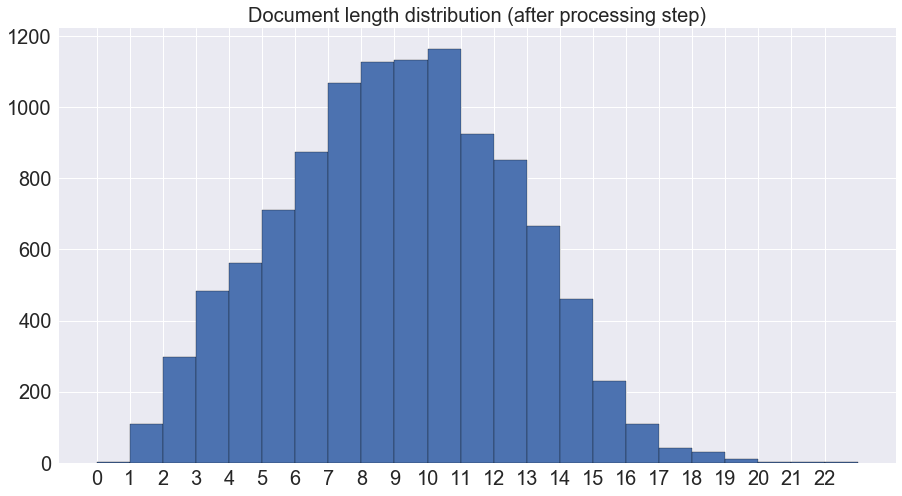

In [14]:
set_size()
plt.subplots(figsize=(15,8))
data['length'].hist(bins=data['length'].max(),edgecolor='black')
plt.xticks(list(range(0,data['length'].max())))
plt.title('Document length distribution (after processing step)')
plt.show()

So we can see the lenght varies from 0 to 24.

#### Top 15 terms frequency

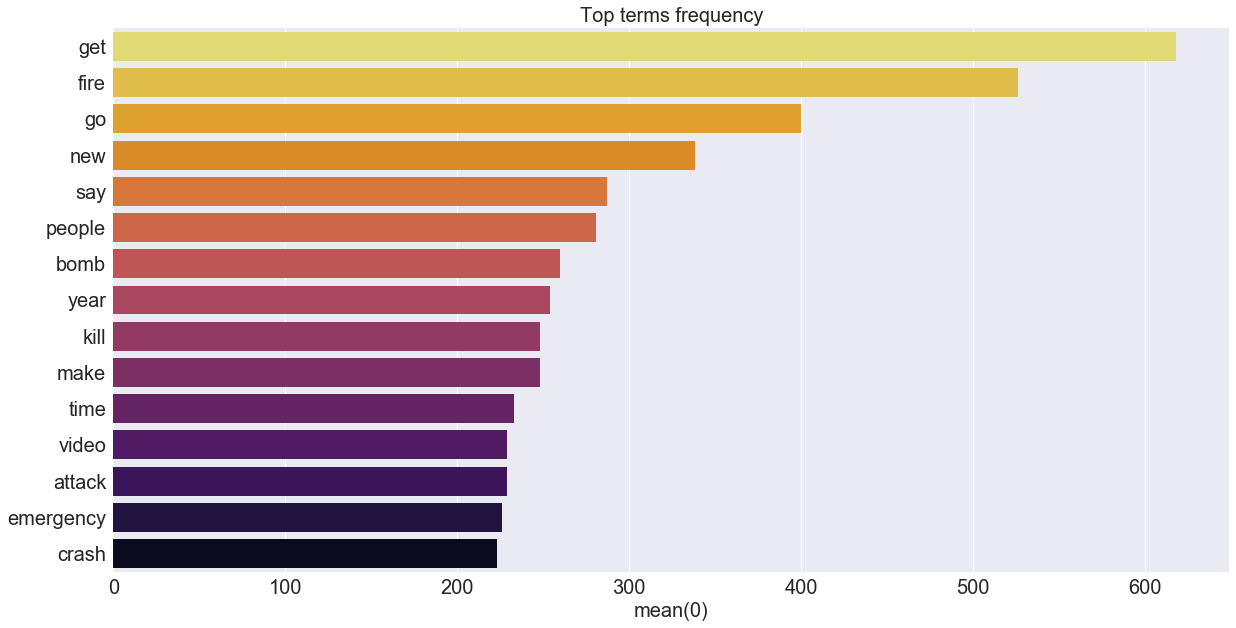

In [15]:
set_size()

terms = []

for text in data['processed_text']:
    for term in text.split():
        terms.append(term)
        
plt1 = pd.Series(terms).value_counts().sort_values(ascending=False)[:15].to_frame()
sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',15))
plt.title('Top terms frequency')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

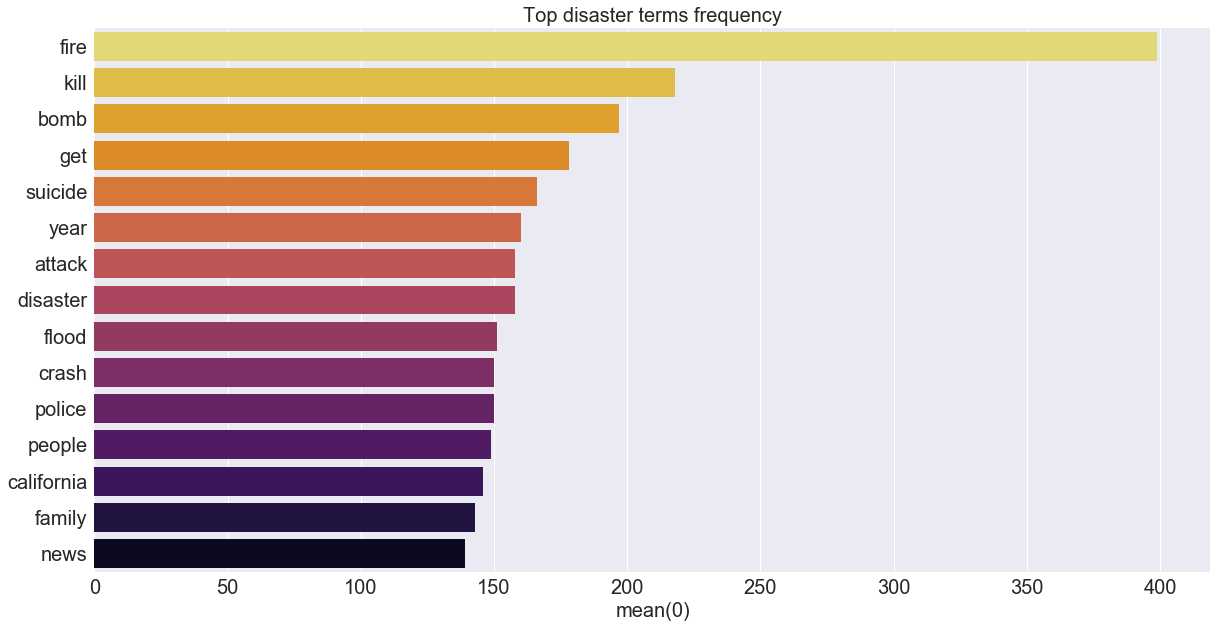

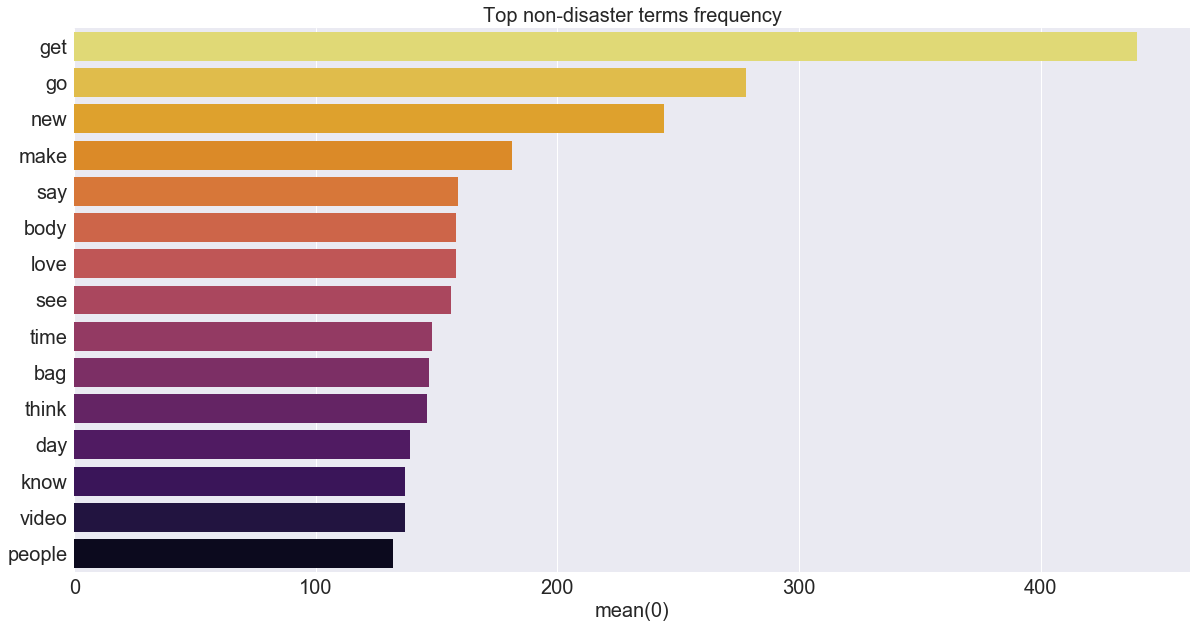

In [16]:
set_size()

disaster_terms = []
non_disaster_terms = []

disaster_data = data[data['class_label'] == 1]
non_disaster_data = data[data['class_label'] == 0]


for text in disaster_data['processed_text']:
    for term in text.split():
        disaster_terms.append(term)
        
plt1 = pd.Series(disaster_terms).value_counts().sort_values(ascending=False)[:15].to_frame()
sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',15))
plt.title('Top disaster terms frequency')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()


for text in non_disaster_data['processed_text']:
    for term in text.split():
        non_disaster_terms.append(term)
        
plt1 = pd.Series(non_disaster_terms).value_counts().sort_values(ascending=False)[:15].to_frame()
sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',15))
plt.title('Top non-disaster terms frequency')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

In [17]:
"Write processed data to disk"

data.to_csv('data/processed_socialmedia_relevant_cols.csv', index=False)

In [18]:
data.head()

,text,class_label,standardized_text,processed_text,length
0,Just happened a terrible car crash,1,just happened a terrible car crash,happen terrible car crash,4
1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this may allah f...,deed reason allah forgive,4
2,"Heard about #earthquake is different cities, s...",1,heard about is different cities stay safe e...,heard different city stay safe everyone,6
3,"there is a forest fire at spot pond, geese are...",1,there is a forest fire at spot pond geese are...,forest fire spot pond geese flee street cannot...,9
4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire la ronge sask canada,6


## 1.2 Classifier

In [19]:
#data = pd.read_csv("data/processed_socialmedia_relevant_cols.csv", encoding='ISO-8859-1', engine='python')
#data.columns=['class_label', 'processed_text', 'length']
#data.head()

#### Create a design matrix

In [20]:
"""
    Let REMOVE all texts that have length smaller than 5, you will see why !!!
"""
filter_data = data[data['length'] > 5]
print("We removed {x} over {y} documents".format(x= (len(data) - len(filter_data)),y =len(data)))
filter_data.describe()

We removed 2164 over 10860 documents


,class_label,length
count,8696.000000,8696.000000
mean,0.476081,9.873390
std,0.499456,2.675289
min,0.000000,6.000000
25%,0.000000,8.000000
50%,0.000000,10.000000
75%,1.000000,12.000000
max,1.000000,23.000000


In [21]:
data.head()

,text,class_label,standardized_text,processed_text,length
0,Just happened a terrible car crash,1,just happened a terrible car crash,happen terrible car crash,4
1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this may allah f...,deed reason allah forgive,4
2,"Heard about #earthquake is different cities, s...",1,heard about is different cities stay safe e...,heard different city stay safe everyone,6
3,"there is a forest fire at spot pond, geese are...",1,there is a forest fire at spot pond geese are...,forest fire spot pond geese flee street cannot...,9
4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire la ronge sask canada,6


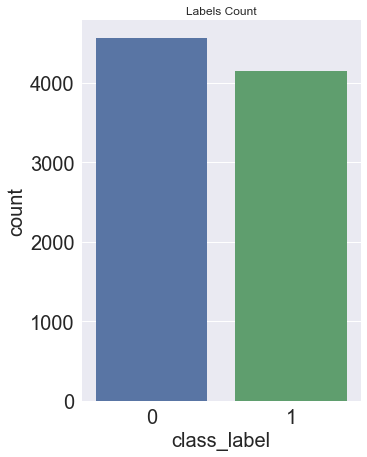

In [22]:
set_size()

plt.subplots(figsize=(5,7))
sns.set(style="darkgrid")
sns.countplot(x=filter_data['class_label'],order=filter_data['class_label'].value_counts().index)
plt.title('Labels Count')
plt.show()

It seems our dataset is a quite balanced

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [24]:
"Voilà, our design matrix X and the response y"

X = filter_data['processed_text']
y = filter_data['class_label']

#### Split data into train, test....

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [26]:
"""Create TF-IDF matrix
   Max DF: ignore terms that have a document frequency strictly higher than this threshold 
   Min DF: ignore terms that have a document frequency strictly lower  than this threshold 
   max_features: maximum number of features (terms) we decide for the design matrix
"""

vocab_size = 2000

tfidf_vectorizer = TfidfVectorizer(max_df=.9, max_features=vocab_size)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test  = tfidf_vectorizer.transform(X_test)

In [27]:
print('TF-IDF matrix of training set has {d} documents decompose in {t} terms'.format(d = tfidf_train.shape[0], t =tfidf_train.shape[1]))
print('TF-IDF matrix of testing  set has {d} documents decompose in {t} terms'.format(d = tfidf_test.shape[0] , t =tfidf_test.shape[1]))

TF-IDF matrix of training set has 6956 documents decompose in 2000 terms
TF-IDF matrix of testing  set has 1740 documents decompose in 2000 terms


In [28]:
tfidf_train.data

array([0.36210256, 0.42190171, 0.43671135, ..., 0.41806479, 0.46299099,
       0.44401055])

In [29]:
tfidf_train.nonzero()

(array([   0,    0,    0, ..., 6955, 6955, 6955], dtype=int32),
 array([ 783,  707, 1112, ..., 1262,    2,  920], dtype=int32))

In [30]:
print('As we can see above, in the training set, doc {d} has a tfidf score {s} at term {t}'.format(d=tfidf_train.nonzero()[0][0],s=tfidf_train.data[0],t=tfidf_train.nonzero()[1][0]))

As we can see above, in the training set, doc 0 has a tfidf score 0.3621025581862755 at term 783


In [31]:
def standardize(x):
    """Standardize the original data set."""
    nbSamples, nbFeatures = x.shape
    for i in range(nbFeatures):
        mean_ = np.mean(x[:,i])
        sd_ = np.std(x[:,i])
        x[:,i] -= mean_
        x[:,i] /= sd_ * np.sqrt(nbSamples)
    return x

#### Project data onto 2 principal components

In [38]:
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.patches as mpatches

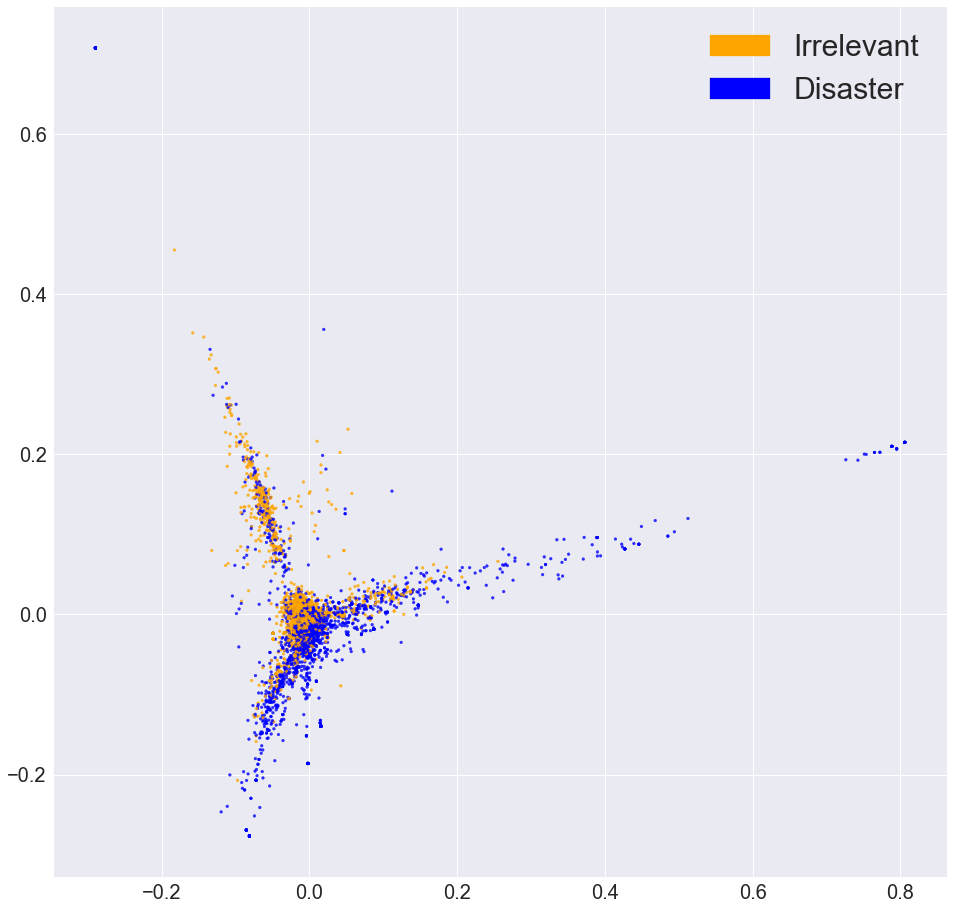

In [41]:
def plot_PCA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        pca = PCA(n_components=2)
        pca.fit(test_data)
        pca_scores = pca.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(pca_scores[:,0], pca_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

        return pca

set_size()
fig = plt.figure(figsize=(16, 16))          
pca = plot_PCA(tfidf_train.todense(), y_train)
plt.show()

#### Classification by Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
logistic = LogisticRegression(n_jobs=-1, random_state=40)

logistic.fit(tfidf_train, y_train)

y_predicted = logistic.predict(tfidf_test)
y_predicted_proba = logistic.predict_proba(tfidf_test)

In [44]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, brier_score_loss

In [45]:
def get_metrics(y_test, y_predicted, y_predicted_proba):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    # brier_score_loss
    brier = brier_score_loss(y_test, y_predicted_proba)
    
    return accuracy, precision, recall, f1, brier

accuracy, precision, recall, f1, brier = get_metrics(y_test, y_predicted, y_predicted_proba[:,1])
print("Accuracy = %.3f, Precision = %.3f, Recall = %.3f, F1 = %.3f , Brier = %.3f" % (accuracy, precision, recall, f1, brier))

Accuracy = 0.805, Precision = 0.806, Recall = 0.805, F1 = 0.805 , Brier = 0.147


Hyperparameter Length: remove all texts if its length < Length:
    
* Length = 3: Accuracy = 0.787, Precision = 0.788, Recall = 0.787, F1 = 0.785 , Brier = 0.151
* Length = 4: Accuracy = 0.793, Precision = 0.793, Recall = 0.793, F1 = 0.792 , Brier = 0.150
* Length = 5: Accuracy = 0.805, Precision = 0.806, Recall = 0.805, F1 = 0.805 , Brier = 0.147
* Length = 6: Accuracy = 0.794, Precision = 0.796, Recall = 0.794, F1 = 0.794 , Brier = 0.149
* Length = 7: Accuracy = 0.796, Precision = 0.797, Recall = 0.796, F1 = 0.796 , Brier = 0.150
* Length = 8: Accuracy = 0.783, Precision = 0.785, Recall = 0.783, F1 = 0.783 , Brier = 0.156


#### Classification with another method

# 2. Text clustering